In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

In [2]:
dataset = pd.read_csv(filepath_or_buffer='pretreatmented_data.csv', header=None)
FEATURES_INDEX = np.arange(50)
LABELS_INDEX = 50
BATCH_SIZE = 50
LOSS_THRESHOLD = 1e-7
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,-0.050634,0.027240,-0.022914,0.037219,0.018378,-0.032899,0.038020,0.007106,-0.014699,-0.013311,...,-0.004743,0.000467,-0.005257,-0.006020,-0.005111,-0.010556,-0.002886,-0.004013,-0.002646,1
1,-0.082828,0.112354,0.009881,0.012665,0.008541,-0.003085,-0.008792,-0.051937,0.034442,0.018615,...,-0.021127,0.002920,0.002466,-0.006346,-0.005416,0.005263,0.001795,-0.001875,-0.005464,1
2,-0.042588,0.001930,0.008672,-0.049124,-0.006528,-0.016737,-0.026704,-0.066970,-0.001077,0.058637,...,-0.005165,-0.002685,0.001238,-0.000939,-0.002155,0.004361,-0.000085,-0.001146,-0.007280,1
3,-0.042608,0.001906,0.008685,-0.049140,-0.006525,-0.016723,-0.026691,-0.066956,-0.001069,0.058653,...,-0.005121,-0.002631,0.001206,-0.001003,-0.002150,0.004290,-0.000087,-0.001166,-0.007277,1
4,-0.005453,-0.084841,-0.021381,-0.010569,0.012817,0.006240,-0.043900,0.008502,-0.095431,-0.005969,...,-0.005556,-0.000033,-0.000223,-0.010339,0.001835,-0.001127,-0.004829,0.001877,-0.010629,1


In [3]:
spam_dataset = dataset[dataset[LABELS_INDEX] == 1]
nonspam_dataset = dataset[dataset[LABELS_INDEX] == 0]
nonspam_dataset.reset_index(drop=True, inplace=True)
spam_dataset.reset_index(drop=True, inplace=True)
nonspam_dataset.tail()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
2708,-0.023177,-0.034199,-0.071174,0.034209,-0.055537,0.050054,0.085029,-0.002683,-0.022024,0.001740,...,-0.000197,-0.003055,0.006381,-0.000235,-0.005397,-0.003612,-0.000170,-0.004931,0.000354,0
2709,-0.068698,0.057827,0.062494,-0.120875,-0.031199,-0.126144,-0.001503,-0.027971,0.042212,-0.037903,...,0.007117,-0.001194,-0.000628,-0.002963,0.001091,0.002984,0.002117,-0.000214,-0.001545,0
2710,-0.022014,-0.018537,-0.052204,-0.010769,-0.049487,0.042335,0.060547,-0.026063,-0.004448,-0.008374,...,-0.015350,-0.018111,0.004594,0.017790,-0.003928,0.013328,0.001513,0.000267,0.002323,0
2711,-0.027492,-0.037501,-0.001082,-0.047973,-0.013806,-0.009351,-0.009311,-0.024605,-0.013044,0.041648,...,0.009767,0.000280,0.005480,-0.005193,-0.005427,-0.004483,-0.003516,-0.003058,0.003073,0
2712,-0.053112,0.017851,-0.001592,-0.010851,-0.040524,-0.143514,0.026496,-0.028555,0.030408,0.003770,...,-0.005770,0.001425,-0.000558,-0.001323,-0.000568,0.003484,-0.000813,-0.002720,0.002752,0


In [4]:
rand_indxs_spam = np.arange(len(spam_dataset))
rand_indxs_nonspam = np.arange(len(nonspam_dataset))
np.random.shuffle(rand_indxs_nonspam)
np.random.shuffle(rand_indxs_spam)

spam_f_threshold = int(len(spam_dataset)*0.6)
spam_s_threshold = int(len(spam_dataset)*0.9)

nonspam_f_threshold = int(len(nonspam_dataset)*0.6)
nonspam_s_threshold = int(len(nonspam_dataset)*0.9)

learn_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[:spam_f_threshold]],
                          nonspam_dataset.iloc[rand_indxs_nonspam[:nonspam_f_threshold]]])

valid_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[spam_f_threshold:spam_s_threshold]],
                          nonspam_dataset.iloc[rand_indxs_nonspam[nonspam_f_threshold:nonspam_s_threshold]]])

test_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[spam_s_threshold:]],
                         nonspam_dataset.iloc[rand_indxs_nonspam[nonspam_s_threshold:]]])

print(len(learn_dataset), len(valid_dataset), len(test_dataset), len(learn_dataset)+len(valid_dataset)+len(test_dataset), len(dataset))

2621 1311 438 4370 4370


In [5]:
learn_dataset = np.array(learn_dataset)
valid_dataset = np.array(valid_dataset)
test_dataset = np.array(test_dataset)

In [6]:
learn_dataloader = DataLoader(learn_dataset, batch_size=BATCH_SIZE, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(50, 20)
        self.lin2 = nn.Linear(20, 10)
        self.lin3 = nn.Linear(10, 10)
        self.lin4 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.tanh(self.lin1(x))
        x = F.tanh(self.lin2(x))
        x = F.sigmoid(self.lin3(x))
        x = F.sigmoid(self.lin4(x))
        return x

net = Net()
net

Net(
  (lin1): Linear(in_features=50, out_features=20, bias=True)
  (lin2): Linear(in_features=20, out_features=10, bias=True)
  (lin3): Linear(in_features=10, out_features=10, bias=True)
  (lin4): Linear(in_features=10, out_features=1, bias=True)
)

In [8]:
is_load = False
if is_load:
    net.load_state_dict(torch.load('gd/net_params.pkl'))

In [9]:
#Инициализация весов
STD = [(2/(50+20+1))**(1/2), (2/(20+10+1))**(1/2), (32/(10+10+1))**(1/2), (32/(10+1+1))**(1/2)]
null_weigth = []
STD.reverse()

def get_weights(layer):
    if (type(layer) == nn.Linear):
        cur_std = STD.pop()
        null_weigth.append(torch.randn(layer.weight.data.shape)*cur_std)
        null_weigth.append(torch.randn(layer.bias.data.shape)*cur_std)

net.apply(get_weights)
for k in null_weigth:
    print(k.shape)
print(null_weigth[1])
null_weigth.reverse()

torch.Size([20, 50])
torch.Size([20])
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])
torch.Size([1, 10])
torch.Size([1])
tensor([-0.1716, -0.3504,  0.1079,  0.1368, -0.1478,  0.1625,  0.1185,
         0.0607,  0.0801, -0.2579,  0.0761,  0.1162,  0.0451, -0.1681,
        -0.1062, -0.0117, -0.2462, -0.1748,  0.0950, -0.0008])


In [10]:
tmp_null_weigth = list(null_weigth)

def init_weigths(layer):
    if(type(layer) == nn.Linear):
        layer.weight.data = (tmp_null_weigth.pop()).clone()
        layer.bias.data = (tmp_null_weigth.pop()).clone()
        
net.apply(init_weigths)
net.lin1.bias

Parameter containing:
tensor([-0.1716, -0.3504,  0.1079,  0.1368, -0.1478,  0.1625,  0.1185,
         0.0607,  0.0801, -0.2579,  0.0761,  0.1162,  0.0451, -0.1681,
        -0.1062, -0.0117, -0.2462, -0.1748,  0.0950, -0.0008])

In [11]:
criterion = nn.BCELoss(size_average=True)

In [12]:
%%time
learn_loss_by_lr = []
valid_loss_by_lr = []
test_loss_by_lr = []
epoch_loss_by_lr = []
lr_list = [0.1, 0.01, 0.001, 0.0001, 0.00001]

for lr in lr_list:
    optimizer = optim.SGD(net.parameters(), lr=lr)
    
    tmp_null_weigth = list(null_weigth)
    net.apply(init_weigths)
    
    learn_epoch_loss = []
    valid_epoch_loss = []
    test_epoch_loss = []
    epoch_list = []
    
    for epoch in range(5*10**4):
        loss_acc = []
        for learn_data in learn_dataloader:
            optimizer.zero_grad()
            features, labels = learn_data[:, FEATURES_INDEX].float(), learn_data[:, LABELS_INDEX].float()
            features.requres_grad = True
            labels.requres_grad = True
            outputs = net(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_acc.append(float(loss.data))
        learn_epoch_loss.append(np.mean(loss_acc))
        
        #критерий останова
        if (epoch > 10) and\
        (abs(learn_epoch_loss[len(learn_epoch_loss) - 3] - learn_epoch_loss[len(learn_epoch_loss) - 4]) < LOSS_THRESHOLD) and\
        (abs(learn_epoch_loss[len(learn_epoch_loss) - 2] - learn_epoch_loss[len(learn_epoch_loss) - 3]) < LOSS_THRESHOLD) and\
        (abs(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2]) < LOSS_THRESHOLD):
            print(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2])
            print('lr: ', lr, ' breaked on epoch: ', epoch, '\n')
            break
            
        if epoch % 1000 == 0:
            epoch_list.append(epoch)
            for valid_data in valid_dataloader:
                features, labels = valid_data[:, FEATURES_INDEX].float(), valid_data[:, LABELS_INDEX].float()
                outputs = net(features)
                loss = criterion(outputs, labels)
                valid_epoch_loss.append(float(loss.data))
                
            for test_data in valid_dataloader:
                features, labels = test_data[:, FEATURES_INDEX].float(), test_data[:, LABELS_INDEX].float()
                outputs = net(features)
                loss = criterion(outputs, labels)
                test_epoch_loss.append(float(loss.data))
                
    learn_loss_by_lr.append(learn_epoch_loss)
    valid_loss_by_lr.append(valid_epoch_loss)
    test_loss_by_lr.append(test_epoch_loss)
    epoch_loss_by_lr.append(epoch_list)

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([1311])) that is different to the input size (torch.Size([1311, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


3.7293538521221414e-08
lr:  0.1  breaked on epoch:  14911 

-8.565971170923503e-08
lr:  0.01  breaked on epoch:  49805 

CPU times: user 1h 58min 45s, sys: 2min 14s, total: 2h 1min
Wall time: 2h 43s


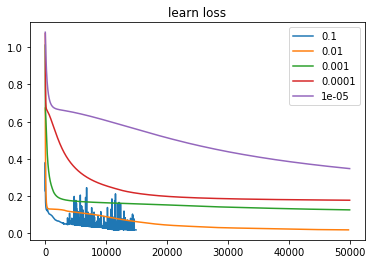

In [13]:
#learn
for num, i in enumerate(lr_list):
    plt.plot(learn_loss_by_lr[num], label=str(i))
plt.title('learn loss')
plt.legend()
plt.savefig('gd/learn_loss.png', bbox_inches='tight')

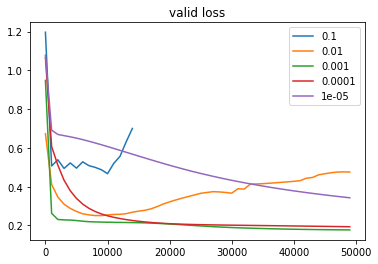

In [14]:
#valid
for num, i in enumerate(lr_list):
    plt.plot(epoch_loss_by_lr[num], valid_loss_by_lr[num], label=str(i))
plt.title('valid loss')
plt.legend()
plt.savefig('gd/valid_loss.png', bbox_inches='tight')

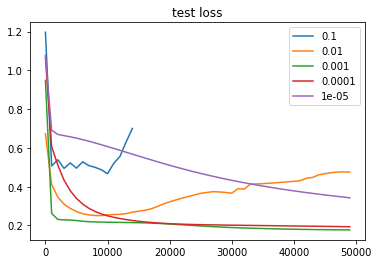

In [15]:
#test
for num, i in enumerate(lr_list):
    plt.plot(epoch_loss_by_lr[num], test_loss_by_lr[num], label=str(i))
plt.title('test loss')
plt.legend()
plt.savefig('gd/test_loss.png', bbox_inches='tight')

0.34789384817177393

In [34]:
for i in range(5):
    print((test_loss_by_lr[i])[-1])

0.7003096342086792
0.4756459891796112
0.1770486682653427
0.19349896907806396
0.34271854162216187


In [17]:
torch.save(net.state_dict(), 'gd/net_params.pkl')